In [1]:
using Mocha
using PyPlot
using WaveletScattering
ws = WaveletScattering

Configuring Mocha...
 * CUDA       disabled by default
 * Native Ext disabled by default
Mocha configured, continue loading module...


DefaultBackend = Mocha.CPUBackend


WaveletScattering

In [107]:
J = 13
Q = 12

data = zeros(Float32, 2^J, 1)
data[1] = 1.0f0
spec = ws.Spec1D(log2_size=J, n_filters_per_octave=2*Q, max_qualityfactor=Q)
bank = ws.Bank1D(spec, max_log2_stride=0)

backend = Mocha.CPUBackend()
signal = ws.InputLayer(
    data = data,
    tops = [:signal],
    symbols = [:time, :chunk])

fourier = ws.FourierLayer(
    bottoms = [:signal],
    pathkeys = [ws.PathKey(:time)],
    tops = [:fourier])

wavelets = ws.WaveletLayer(
    bank = bank,
    bottoms = [:fourier],
    tops = [:wavelets])

invfourier = ws.InvFourierLayer(
    bottoms = [:wavelets],
    pathkeys = [ws.PathKey(:time)],
    tops = [:invfourier])

modulus = ws.PointwiseLayer(
    bottoms = [:invfourier],
    tops = [:modulus],
    ρ = ws.Modulus())

layers = Mocha.Layer[
    signal,
    fourier,
    wavelets,
    invfourier,
    modulus]

Mocha.init(backend)
@time net = Mocha.Net("network", backend, layers);

28-Feb 15:26:15:INFO:root:Constructing net network on Mocha.CPUBackend...
28-Feb 15:26:15:INFO:root:Topological sorting 5 layers...
28-Feb 15:26:15:INFO:root:Setup layers...
28-Feb 15:26:16:INFO:root:Network constructed!
  0.649255 seconds (3.51 M allocations: 102.404 MB, 18.97% gc time)


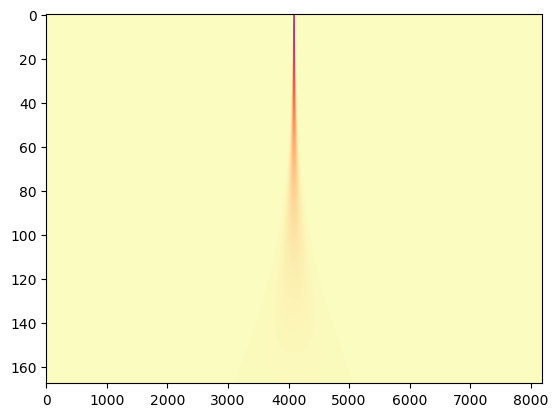

PyObject <matplotlib.image.AxesImage object at 0x32a060b10>

In [108]:
paths = [ ws.Path(ws.PathKey(:j,:time) => j) for j in 0:6]
octaves = [ net.states[end].blobs[1].nodes[path].data for path in paths]

U1 = cat(4, octaves...)
U1 = reshape(U1, size(U1, 1), size(U1, 3) * size(U1, 4))

X = -fftshift(U1, 1).'

imshow(X[:, :], aspect="auto", cmap=ColorMap("magma"))

In [111]:
sum(abs2(data))

1.0f0

In [112]:
sum(abs2(X))

136.93504f0